# Notebook Setup

In [2]:
import os
from pathlib import Path
from urllib.parse import urlparse

import pandas as pd

import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [56]:
WORK_DIR = Path(os.getcwd()).parent

DATA_DIR = WORK_DIR / 'data'
green_taxi_2021_01_path = DATA_DIR / 'green_tripdata_2021-01.parquet'
green_taxi_2021_02_path = DATA_DIR / 'green_tripdata_2021-02.parquet'

MODEL_DIR = WORK_DIR / 'models'

DIR_LIST = [
    DATA_DIR,
    MODEL_DIR
]

for dir in DIR_LIST:
    if not dir.exists():
        os.mkdir(dir)

# Data Download

In [43]:
# from https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page
data_uri_list = [
    'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet',
    'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet',
    ]

for data_uri in data_uri_list:
    data_uri_name = os.path.basename(urlparse(data_uri).path)
    if not (DATA_DIR / data_uri_name).exists():
        os.system(f'wget {data_uri} -P {str((DATA_DIR / data_uri_name).parent)}')
    else:
        print('file already exist, skipping download...')

file already exist, skipping download...
file already exist, skipping download...


# Model Training

In [44]:
df = pd.read_parquet(green_taxi_2021_01_path)

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [45]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/home/arasyidi/miniconda3/envs/mlops_zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829628

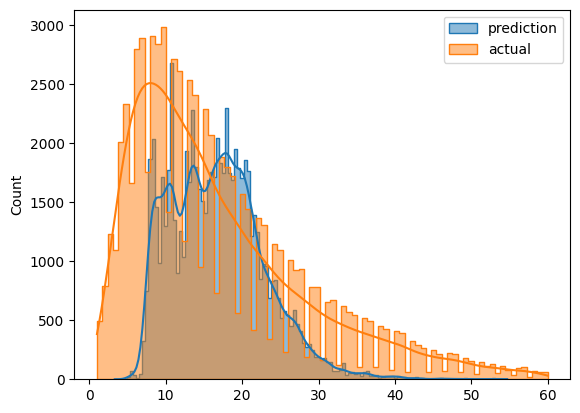

In [46]:
sns.histplot(y_pred, label='prediction', kde=True, element="step")
sns.histplot(y_train, label='actual', kde=True, element="step")

plt.legend()

In [47]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [49]:
df_train = read_dataframe(str(green_taxi_2021_01_path))
df_val = read_dataframe(str(green_taxi_2021_02_path))

In [50]:
len(df_train), len(df_val)

(73908, 61921)

In [51]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [52]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [53]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [54]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/arasyidi/miniconda3/envs/mlops_zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715202840848

In [57]:
model_name = 'lin_reg.bin'

with open(MODEL_DIR / model_name, 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [58]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/arasyidi/miniconda3/envs/mlops_zoomcamp/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


11.167275941179728